# **Diplomado de Machine Learning con Python**
## Tarea 05 – Sesión 07

## **Preprocesamiento**

Para esta tarea se utilizará la tabla **datos_preproc_practica.csv**. 


![preprocessing data](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ckcmcUm9CcJh9LNQMo3alA.png)

### Heurística de imputación (recom_imputer)
- Si hay **muchos atípicos** (outliers_% ≥ 5%) o **fuerte asimetría** (|skew| ≥ 1.0) ⇒ usar **median**.  
- En otro caso ⇒ usar **mean**.

### Heurística de escalado (recom_scaler)
- Si outliers_% ≥ 5% ⇒ usar **RobustScaler**.  
- Si no hay muchos outliers y la distribución es casi simétrica (|skew| ≤ 0.5) ⇒ usar **StandardScaler**.  
- En cualquier otro caso ⇒ usar **MinMaxScaler** (por defecto).


## Importación de librerías y lectura de archivo csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# --- Cargar CSV (ajusta la ruta si hace falta) ---
#############################################
#############################################

df = pd.read_csv("data/datos_preproc_practica.csv")

#############################################
#############################################

df.head()

,edad,ingreso_mensual,talla_cm,peso_kg,temperatura_c,frecuencia_cardiaca,ciudad,tipo_servicio,nivel,codigo_serie,referencia,sensor_defectuoso
0,39.0,NaN,174.287097,78.317375,NaN,76.552698,Puebla,basico,alto,Z,REF-964053,NaN
1,NaN,16048.0,168.917333,73.530586,36.332796,NaN,Puebla,estandar,medio,Y,REF-147729,NaN
2,44.0,41790.0,161.139089,94.093905,36.117298,96.188603,NaN,basico,alto,X,REF-867825,NaN
3,NaN,13803.0,160.267146,71.686776,36.251983,89.602824,Puebla,estandar,bajo,NaN,REF-406327,NaN
4,15.0,NaN,NaN,50.069666,NaN,64.701549,Guadalajara,estandar,alto,X,REF-159441,NaN


## Revisión inicial de los datos

In [209]:
# Resumen de los datos

d_type = df.dtypes # Tipo de dato
n_non_null = df.count() # Numero de valores no nulos
n_unique = df.nunique() # Numero de valores unicos
n_null = df.isnull().sum() # Numero de valors nulos
ratio_null = df.isnull().sum()/df.shape[0] # Porcentaje de valores nulos

pd.DataFrame(
    {"d_type": d_type,
     "n_non_null": n_non_null,
     "n_unique": n_unique,
     "n_null": n_null,
     "ratio_null": ratio_null}
)

,d_type,n_non_null,n_unique,n_null,ratio_null
edad,float64,381,57,119,0.238
ingreso_mensual,float64,405,403,95,0.190
talla_cm,float64,446,446,54,0.108
peso_kg,float64,434,432,66,0.132
temperatura_c,float64,421,421,79,0.158
frecuencia_cardiaca,float64,378,378,122,0.244
ciudad,object,410,5,90,0.180
tipo_servicio,object,399,3,101,0.202
nivel,object,405,3,95,0.190
codigo_serie,object,430,3,70,0.140


In [210]:
df.describe()

,edad,ingreso_mensual,talla_cm,peso_kg,temperatura_c,frecuencia_cardiaca,sensor_defectuoso
count,381.000000,405.000000,446.000000,434.000000,421.000000,378.000000,43.000000
mean,36.223097,21882.474860,167.991549,73.189043,36.682513,76.630167,-0.032688
std,15.056738,15714.795822,9.484114,13.525559,0.571884,12.114607,0.944514
min,15.000000,2016.000000,141.399431,40.000000,35.527677,41.661780,-3.110488
25%,27.000000,11741.000000,161.851488,64.283555,36.389489,67.873656,-0.446572
50%,34.000000,18065.000000,168.245734,73.738661,36.643309,76.025219,-0.017434
75%,42.000000,26300.000000,174.273273,82.493571,36.876278,85.000631,0.680576
max,109.000000,121229.000000,193.282898,115.799425,40.304299,112.714375,1.283845


## Separación de datos de entrenamiento y prueba (X_train, X_test)


In [211]:
X_train, X_test = train_test_split(df, test_size=0.25, random_state=0)

# Revisar tamaños
print(f'Tamaño entrenamiento X_train: {X_train.shape}')
print(f'Tamaño prueba X_test: {X_test.shape}')

Tamaño entrenamiento X_train: (375, 12)
Tamaño prueba X_test: (125, 12)


## Diagnóstico de columnas numéricas

### Creación de funciones para análisis de outliers y rangos acotados

In [212]:
# ================================
# Creación de funciones auxiliares
# ================================

# Esta función analiza una serie numérica (s) para detectar outliers usando el método del rango intercuartílico (IQR).
def iqr_outlier_stats(s: pd.Series):
    s = pd.to_numeric(s, errors="coerce").dropna()  # Asegura que la serie sea numérica y sin NaN
    if s.empty:
        return 0, 0.0, np.nan, np.nan, np.nan, np.nan  # Devuelve valores nulos si la serie está vacía
    q1, q3 = s.quantile(0.25), s.quantile(0.75)       # Calcula cuartiles
    iqr = q3 - q1                                     # Rango intercuartílico
    lim_inf, lim_sup = q1 - 1.5*iqr, q3 + 1.5*iqr     # Límites para detectar outliers
    n_out = int(((s < lim_inf) | (s > lim_sup)).sum())# Cuenta valores fuera de los límites
    prop_out = n_out / len(s)                         # Proporción de outliers
    return n_out, prop_out, q1, q3, lim_inf, lim_sup  # Devuelve estadísticas clave

# Esta función sirve para diagnosticar si una columna numérica parece representar proporciones o porcentajes
def bounded_guess(s: pd.Series):
    """Detecta si una serie parece estar acotada en [0,1] o [0,100]."""
    s = pd.to_numeric(s, errors="coerce").dropna()     # Convierte a numérico y elimina NaN
    if s.empty:
        return None                                    # Si está vacía, no se puede diagnosticar
    mn, mx = float(s.min()), float(s.max())            # Calcula mínimo y máximo
    if 0.0 <= mn and mx <= 1.0:
        return "[0,1]"                                 # Parece una proporción
    if 0.0 <= mn and mx <= 100.0:
        return "[0,100]"                               # Parece un porcentaje
    return None                                        # No parece estar acotada

### Visualización exploratoria de las columnas numéricas

Columnas numéricas: ['edad', 'ingreso_mensual', 'talla_cm', 'peso_kg', 'temperatura_c', 'frecuencia_cardiaca', 'sensor_defectuoso']


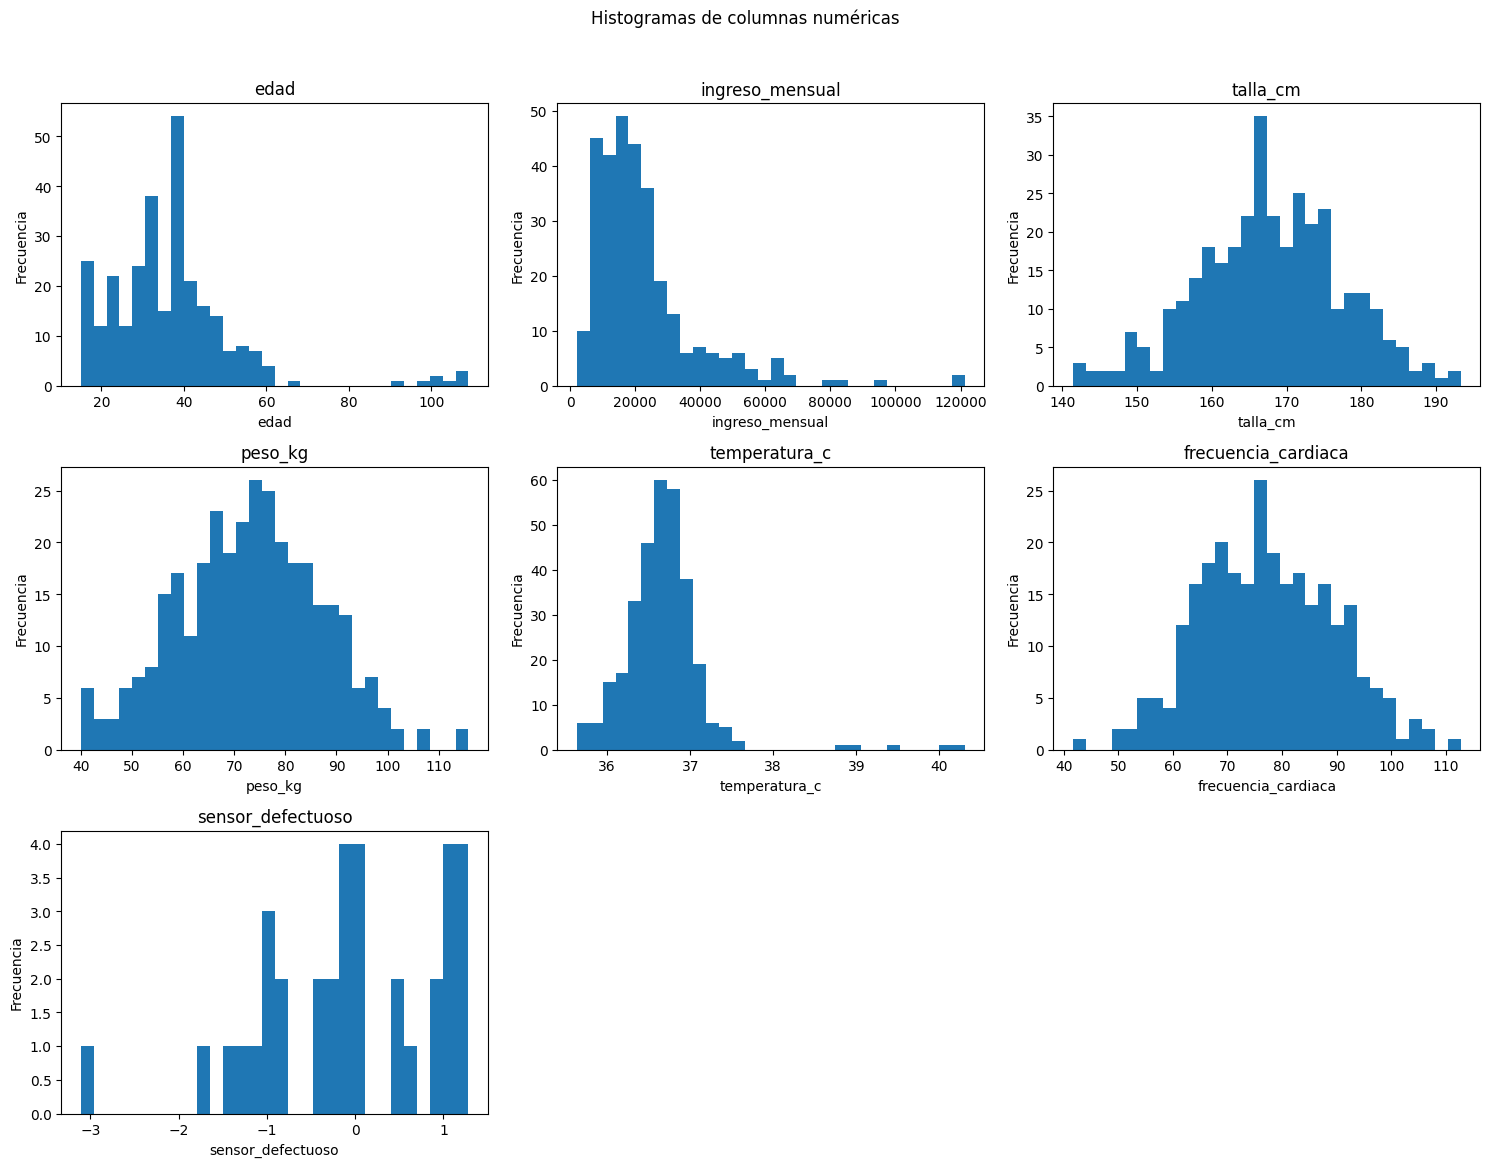

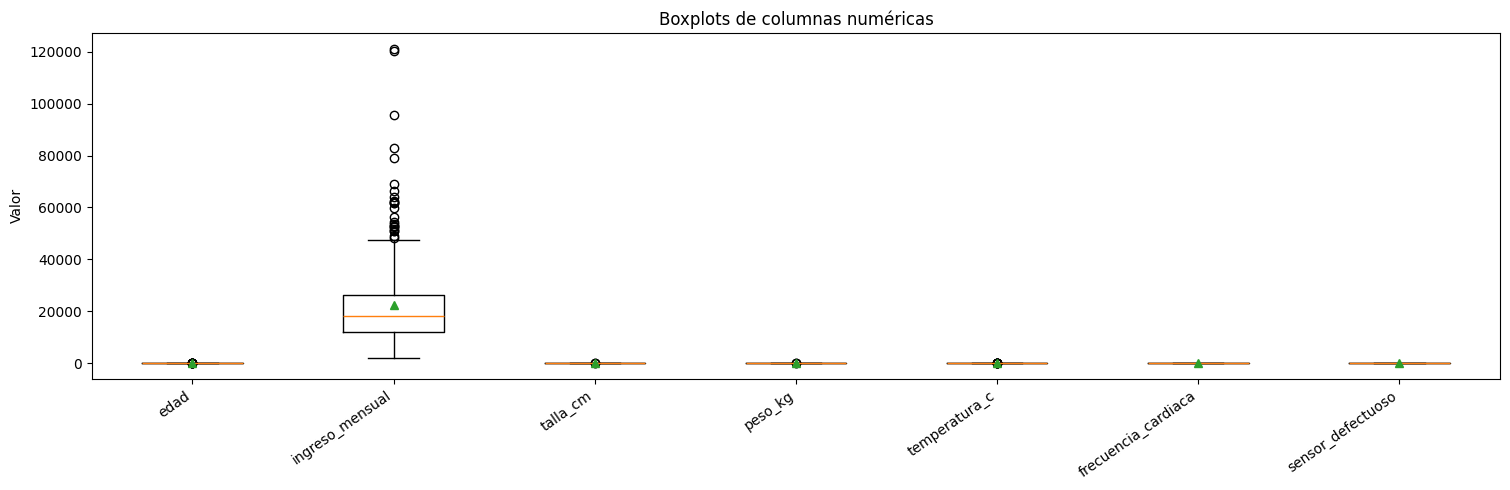

In [ ]:
# =======================================
# Generación de gráficos para diagnóstico
# =======================================

# Detectar columnas numéricas
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print("Columnas numéricas:", num_cols) # Lista con los nombres de las columnas numericas


# Este bloque genera una visualización diagnóstica de las columnas numéricas en X_train usando histogramas y boxplots.
if len(num_cols) == 0:
    print("No hay columnas numéricas en X_train. No se generan imágenes.")
else:
    # --------- Figura 1: HISTOGRAMAS (todos en subplots) ----------
    n = len(num_cols)                          # Número total de columnas numéricas
    ncols = min(3, n)                          # Máximo 3 columnas por fila
    nrows = math.ceil(n / ncols)               # Calcula cuántas filas se necesitan

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()        # Asegura que axes sea un array plano

    for i, col in enumerate(num_cols):
        s = pd.to_numeric(X_train[col], errors="coerce").dropna()  # Limpia la columna
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")  # Mensaje si está vacía
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)               # Histograma con 30 bins
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Oculta subplots sobrantes
    for j in range(len(num_cols), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas de columnas numéricas", y=1.02, fontsize=12)
    fig.tight_layout()
    fig.savefig("figures/histogramas_numericas.png", dpi=150, bbox_inches="tight")
    plt.show()
    #plt.close(fig)

    # --------- Figura 2: BOXPLOTS (todas en un eje) ----------
    series_pairs = []
    for c in num_cols:
        v = pd.to_numeric(X_train[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos numéricos válidos para boxplots. No se genera boxplot.")
        box_path = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots de columnas numéricas")
        plt.tight_layout()
        fig2.savefig("/figures/boxplots_numericas.png", dpi=150, bbox_inches="tight")
        plt.show()
        #plt.close(fig2)

### Diagnóstico automatizado de columnas númericas

In [214]:
# =================================
# Diagnóstico numérico + heurística
# =================================

diagnostico = []  # Lista para guardar el resumen estadístico y recomendaciones por variable

for c in num_cols:
    s = pd.to_numeric(X_train[c], errors="coerce")  # Convierte la columna a numérica y fuerza NaN si hay errores
    miss_pct = s.isna().mean() * 100                # Calcula el porcentaje de valores faltantes
    s_no_na = s.dropna()                            # Elimina NaN para calcular estadísticas robustas
    skew = s_no_na.skew() if s_no_na.size > 1 else np.nan     # Asimetría (sesgo)
    kurt = s_no_na.kurt() if s_no_na.size > 1 else np.nan     # Curtosis (forma de la distribución)

    # Detecta outliers usando el rango intercuartílico
    n_out, prop_out, q1, q3, li, ls = iqr_outlier_stats(s)
    # Detecta si la variable parece estar acotada en [0,1] o [0,100]
    bounds = bounded_guess(s)

    # Heurística para elegir imputador: mediana si hay outliers o fuerte sesgo
    # Si hay al menos 5% de outliers o la distribución es muy sesgada (|skew| ≥ 1), se prefiere la mediana.
    if (prop_out >= 0.05) or (pd.notna(skew) and abs(skew) >= 1.0):
        imputador = "median"
    else:
        imputador = "mean"

    # Heurística para elegir escalador
    if prop_out >= 0.05:
        escalador = "RobustScaler" # Si hay ≥ 5% de outliers, se recomienda RobustScaler por su resistencia a valores extremos.
    elif pd.notna(skew) and abs(skew) <= 0.5:
        escalador = "StandardScaler" # Si la distribución es aproximadamente simétrica (|skew| ≤ 0.5), se usa StandardScaler.
    else:
        escalador = "MinMaxScaler"  # Por defecto si no es simétrica ni robusta

    # Guarda el diagnóstico completo en la lista
    diagnostico.append({
        "columna": c,
        "missing_%": round(miss_pct, 2),
        "skew": round(skew, 3) if pd.notna(skew) else np.nan,
        "kurtosis": round(kurt, 3) if pd.notna(kurt) else np.nan,
        "outliers_n": n_out,
        "outliers_%": round(prop_out*100, 2),
        "q1": q1, "q3": q3, "IQR": (q3 - q1),
        "lim_inf": li, "lim_sup": ls,
        "bounded": bounds,
        "recom_imputer": imputador,
        "recom_scaler": escalador,
    })


# Convierte la lista de diagnósticos en un DataFrame ordenado por % de outliers y % de missing
diag_df = pd.DataFrame(diagnostico).sort_values(["outliers_%", "missing_%"], ascending=False)

# Muestra el encabezado del diagnóstico en consola
print("\n=== Diagnóstico numérico (heurística) ===\n")

print(diag_df) # Imprime el DataFrame con estadísticas y recomendaciones por variable
print("\n", diag_df[['columna', 'recom_imputer', 'recom_scaler']]) # Imprime solo las recomendaciones por variable


=== Diagnóstico numérico (heurística) ===

               columna  missing_%   skew  kurtosis  outliers_n  outliers_%  \
1      ingreso_mensual      18.93  2.509     9.280          24        7.89   
0                 edad      23.20  2.009     6.932           9        3.12   
4        temperatura_c      15.73  3.031    18.198           8        2.53   
3              peso_kg      12.27  0.024    -0.169           2        0.61   
2             talla_cm       9.60 -0.121    -0.066           2        0.59   
6    sensor_defectuoso      90.67 -0.719     0.689           0        0.00   
5  frecuencia_cardiaca      26.13  0.122    -0.278           0        0.00   

             q1            q3           IQR      lim_inf       lim_sup  \
1  12193.250000  26335.750000  14142.500000 -9020.500000  47549.500000   
0     28.000000     42.000000     14.000000     7.000000     63.000000   
4     36.418454     36.872642      0.454188    35.737171     37.553924   
3     63.940191     82.726023     1

## Agrupacíón automática de las columnas según el tratamiento recomendado

In [215]:
# Sugerencias de bloques numéricos (incluye median+Robust)
suggest_mean_rob = diag_df.query("recom_imputer=='mean' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_rob  = diag_df.query("recom_imputer=='median' and recom_scaler=='RobustScaler'")["columna"].tolist()
suggest_med_min  = diag_df.query("recom_imputer=='median' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_med_std  = diag_df.query("recom_imputer=='median' and recom_scaler=='StandardScaler'")["columna"].tolist()
suggest_mean_min = diag_df.query("recom_imputer=='mean' and recom_scaler=='MinMaxScaler'")["columna"].tolist()
suggest_mean_std = diag_df.query("recom_imputer=='mean' and recom_scaler=='StandardScaler'")["columna"].tolist()

print("\nSugerencias de bloques numéricos (auto):")
print("median+Robust   :", suggest_med_rob)
print("median+MinMax   :", suggest_med_min)
print("median+Standard :", suggest_med_std)
print("mean+Robust     :", suggest_mean_rob)
print("mean+MinMax     :", suggest_mean_min)
print("mean+Standard   :", suggest_mean_std)


Sugerencias de bloques numéricos (auto):
median+Robust   : ['ingreso_mensual']
median+MinMax   : ['edad', 'temperatura_c']
median+Standard : []
mean+Robust     : []
mean+MinMax     : ['sensor_defectuoso']
mean+Standard   : ['peso_kg', 'talla_cm', 'frecuencia_cardiaca']


## Listas de columnas agrupadas por tipo de tratamiento

In [216]:
# --- Listas de columnas ---

# Numéricas
# num_med_rob_cols: inputacion mediana con escalado robusto
# num_med_min_cols: inputación mediana con escalado min_max
# num_med_std_cols: inputacion mediana con escalado Estandar
# num_mean_rob_cols: inputación media con escalado robusto
# num_mean_min_cols: inputacion media con escalado min_max
# num_mean_std_cols: inputacion media con escalado Estandar

# Categóricas
# cat_ohe_cols: inputacion moda con OneHot
# cat_ord_cols: inputacion moda con Ordinal

#########################################################
#########################################################

num_med_rob_cols = ['ingreso_mensual', 'edad']   # mediana + Robust
#num_med_min_cols = []   # mediana + MinMax
num_med_std_cols = ['temperatura_c']   # mediana + Estandar
#num_mean_rob_cols = []   # media + Robust
#num_mean_min_cols  = []    # media + MinMax
num_mean_std_cols  = ['peso_kg', 'talla_cm', 'frecuencia_cardiaca']    # media + Standard

cat_ohe_cols = ["ciudad","tipo_servicio"]                  # moda + OneHot
cat_ord_cols = ["nivel","codigo_serie"]                  # moda + Ordinal

#########################################################
#########################################################

passthrough_cols = ["referencia"]                      # pasar sin procesar
drop_cols        = ["sensor_defectuoso"]                         # eliminar

###### orden de las categorías ordinales
categorias_ordinales = [
    ["bajo","medio","alto"],
    ["Z","Y","X"]

]

#########################################################
#########################################################

## Definición de los pipelines de preprocesamiento

In [217]:
# --- Pipelines NUMÉRICOS ---
pipe_med_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  RobustScaler())
])

'''pipe_med_min = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  MinMaxScaler())
])'''

pipe_med_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])


'''pipe_mean_rob = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  RobustScaler())
])'''

'''pipe_mean_min = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  MinMaxScaler())
])'''

pipe_mean_std = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])

# --- Pipelines CATEGÓRICOS ---
pipe_cat_ohe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # moda
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pipe_cat_ord = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # moda
    ("encoder", OrdinalEncoder(categories=categorias_ordinales,
                               handle_unknown="use_encoded_value", unknown_value=-1))
])


## Construcción del ColumnTransformer para preprocesamiento

En este bloque `preprocessor` es un objeto ColumnTransformer que agrupa:

* Pipelines numéricos (imputación + escalado)
* Pipelines categóricos (imputación + codificación)
* Columnas que se pasan sin procesar (passthrough)
* Columnas que se eliminan (drop)

In [218]:
# --- ColumnTransformer unificado ---

'''Cada tupla aplica un pipeline (pipe_mean_rob) a un grupo de columnas (num_mean_rob_cols)

num_med_rob → alias interno del bloque
pipe_mean_rob → el pipeline que se va a aplicar
num_mean_rob_cols → la lista de columnas a las que se aplica
'''

preprocessor = ColumnTransformer(
    transformers=[
        ("num_med_rob", pipe_med_rob, num_med_rob_cols),
        #("num_med_min", pipe_med_min, num_med_min_cols),
        ("num_med_std", pipe_med_std, num_med_std_cols),
        #("num_mean_rob",  pipe_mean_rob,  num_mean_rob_cols),
        #("num_mean_min",  pipe_mean_min,  num_mean_min_cols),
        ("num_mean_std",  pipe_mean_std,  num_mean_std_cols),

        # Categóricos
        ("cat_ohe",      pipe_cat_ohe,  cat_ohe_cols),
        ("cat_ord",      pipe_cat_ord,  cat_ord_cols),

        # Passthrough (sin preprocesar)
        ("passthrough",  "passthrough", passthrough_cols),

        # Drop explícito
        ("drop_high_na", "drop", drop_cols),
    ],
    remainder="drop",                        # descarta cualquier otra columna no listada
    verbose_feature_names_out=False
)

# Visualizar preprocessor
preprocessor

ColumnTransformer(transformers=[('num_med_rob',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler())]),
                                 ['ingreso_mensual', 'edad']),
                                ('num_med_std',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['temperatura_c']),
                                ('num_mean_std',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', Standard...
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder(categories=[['bajo',
                                                                              'medio',
                                                                              'alto'],
                                                                             ['Z',
                                                                              'Y',
                                                                              'X']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['nivel', 'codigo_serie']),
                                ('passthrough', 'passthrough', ['referencia']),
                                ('drop_high_na', 'drop',
                                 ['sensor_defectuoso'])],
                  verbose_feature_names_out=False)

## Aplicación del preprocesamiento a datos de entrenamiento y prueba (X_train, X_test)

* `.fit()` aprende → solo sobre X_train

* `.transform()` aplica → tanto a X_train como a X_test

In [219]:
# ---------- Ajuste y transformación ----------

# Calcula los parámetros necesarios para cada transformación
# Ajusta cada sub-pipeline usando solo X_train
# No toca X_test aún para evitar fuga de datos
preprocessor.fit(X_train)

# Aplica las transformaciones aprendidas a X_train y X_test
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Shape train ->", X_train_proc.shape)
print("Shape test  ->", X_test_proc.shape)

# El resultado es una matriz NumPy con todas las columnas procesadas:
print("\n X_train: \n", X_train_proc)

Shape train -> (375, 17)
Shape test  -> (125, 17)

 X_train: 
 [[0.8232880225698898 -0.7 -0.14587467510202307 ... 2.0 1.0 'REF-931711']
 [-0.9575788663759939 1.1 -1.4325862912925296 ... 0.0 0.0 'REF-621328']
 [0.0 -0.2 0.41682308391125444 ... 1.0 0.0 'REF-836665']
 ...
 [0.6492946909463965 6.5 -0.7097685814344767 ... 2.0 0.0 'REF-869073']
 [0.18681713259810206 0.2 1.5118179027108952e-14 ... 1.0 2.0 'REF-616866']
 [-0.7557835342395486 -0.6 1.5118179027108952e-14 ... 0.0 1.0
  'REF-267693']]


## Reconstruir DataFrame con las variables transformadas


In [220]:
# Reconstruir DataFrame con nombres de columnas

# Devuelve una lista con los nombres de las columnas resultantes después de aplicar el preprocesamiento.
cols_out = preprocessor.get_feature_names_out()
# Reconstruye los datos procesados como DataFrame con nombres legibles
X_train_proc_df = pd.DataFrame(X_train_proc, columns=cols_out)
X_test_proc_df = pd.DataFrame(X_test_proc, columns=cols_out)

# Versión final de X_train procesado
X_train_proc_df

,ingreso_mensual,edad,temperatura_c,peso_kg,talla_cm,frecuencia_cardiaca,ciudad_CDMX,ciudad_Guadalajara,ciudad_Monterrey,ciudad_Puebla,ciudad_Toluca,tipo_servicio_basico,tipo_servicio_estandar,tipo_servicio_premium,nivel,codigo_serie,referencia
0,0.823288,-0.7,-0.145875,0.247459,-2.090468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,REF-931711
1,-0.957579,1.1,-1.432586,1.352001,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,REF-621328
2,0.0,-0.2,0.416823,-0.781908,-0.270125,-0.898576,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,REF-836665
3,-0.608977,0.0,0.0,1.523255,-1.567863,-0.457336,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,REF-634251
4,3.081713,-2.1,7.725797,-0.550561,-0.356724,-0.156571,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,REF-891035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.419082,0.8,0.946399,0.313261,0.397362,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,REF-268778
371,-0.252988,-0.6,-0.84353,-0.404191,0.348595,0.008297,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,REF-462559
372,0.649295,6.5,-0.709769,0.282794,0.0,-2.143247,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,REF-869073
373,0.186817,0.2,0.0,-0.339252,-0.240959,0.821469,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,REF-616866


### Exportación de datos preprocesados a archivos CSV

In [ ]:
X_train_proc_df.to_csv("data/processed/train_processed.csv",index=False)
X_test_proc_df.to_csv("data/processed/test_processed.csv",index=False)

## Visualización de columnas escaladas

Columnas escaladas encontradas en X_train_proc_df: ['ingreso_mensual', 'edad', 'temperatura_c', 'peso_kg', 'talla_cm', 'frecuencia_cardiaca']


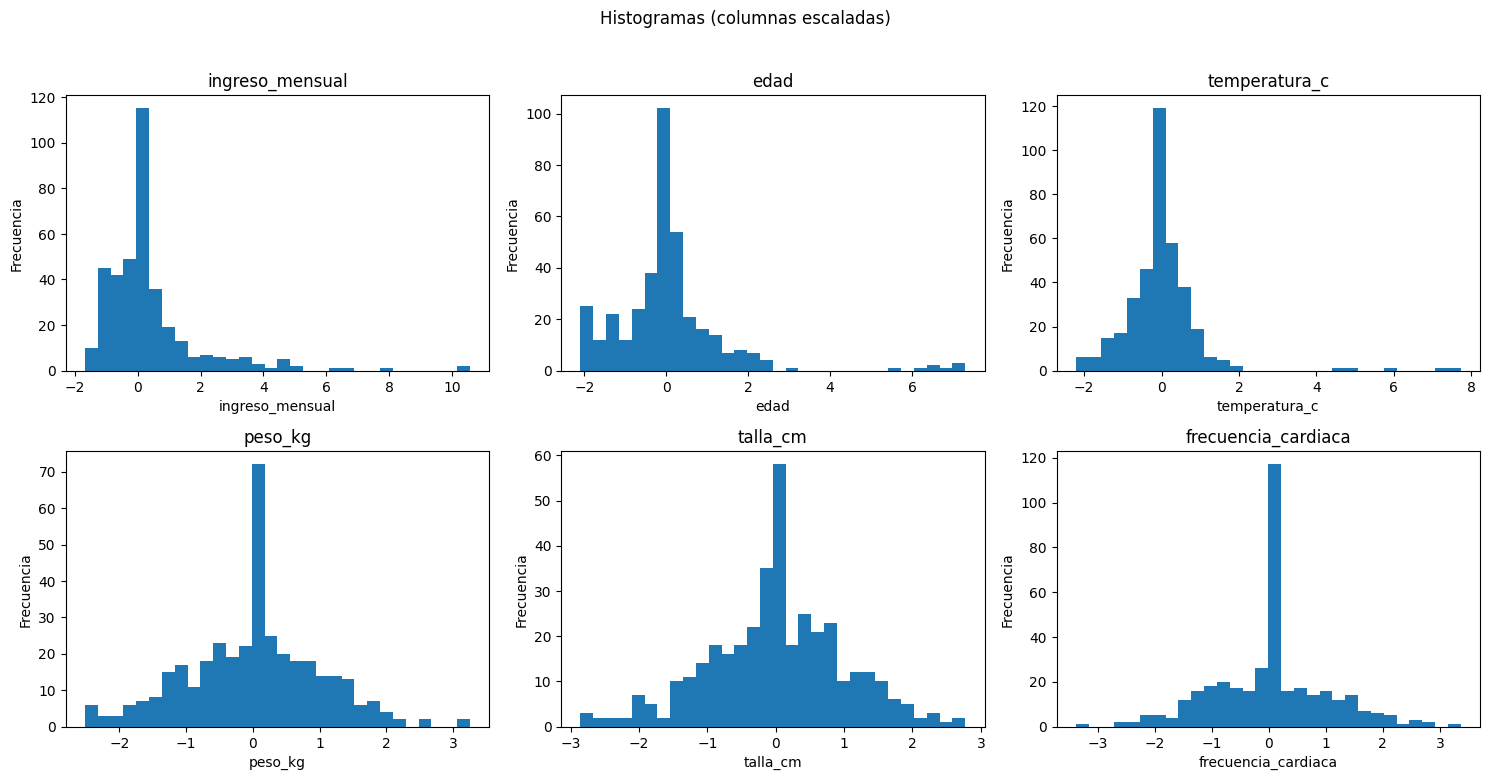

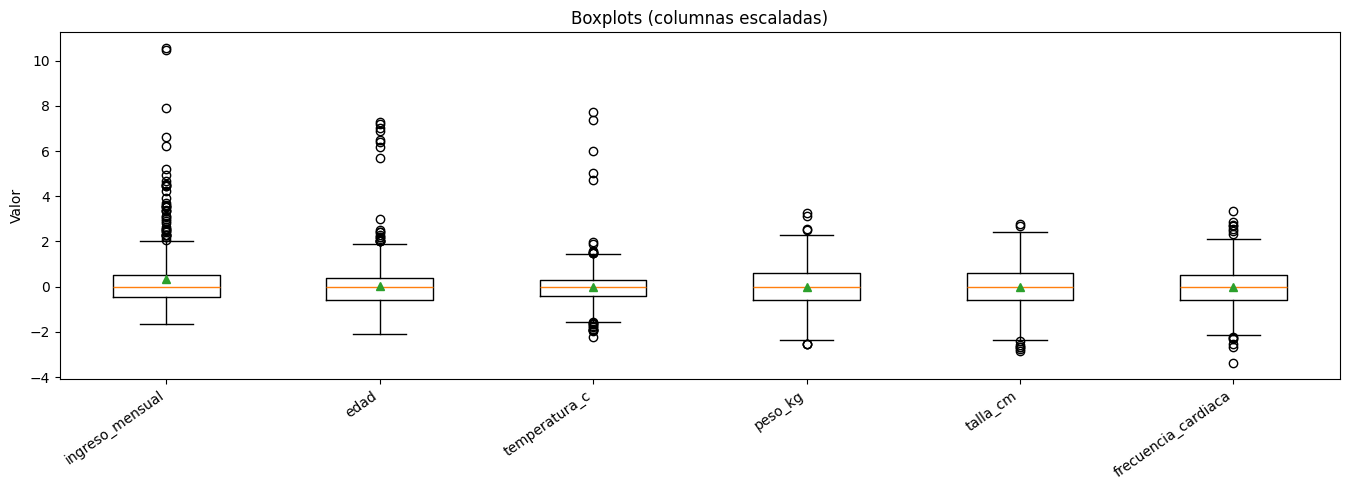

Imágenes guardadas:
 - scaled_histogramas.png
 - scaled_boxplots.png


In [ ]:
# Columnas escaladas que indicaste:

#############################################
#############################################

cols_escaladas_usuario = ['ingreso_mensual', 'edad', 'temperatura_c',
                          'peso_kg', 'talla_cm', 'frecuencia_cardiaca']

#############################################
#############################################

cols = [c for c in cols_escaladas_usuario if c in X_train_proc_df.columns]
print(f"Columnas escaladas encontradas en X_train_proc_df: {cols}")

if len(cols) == 0:
    print("No hay columnas escaladas válidas en X_train_proc_df. No se generan imágenes.")
else:
    # ---------- Figura 1: HISTOGRAMAS (todas en subplots) ----------
    n = len(cols)
    ncols = min(3, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3.8*nrows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(cols):
        s = pd.to_numeric(X_train_proc_df[col], errors="coerce").dropna()
        ax = axes[i]
        if s.empty:
            ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
            ax.set_title(col); ax.set_xlabel(col); ax.set_ylabel("Frecuencia")
            ax.set_xticks([]); ax.set_yticks([])
        else:
            ax.hist(s, bins=30)
            ax.set_title(col)
            ax.set_xlabel(col)
            ax.set_ylabel("Frecuencia")

    # Ocultar subplots sobrantes
    for j in range(len(cols), len(axes)):
        axes[j].axis("off")

    fig.suptitle("Histogramas (columnas escaladas)", y=1.02, fontsize=12)
    fig.tight_layout()
    hist_file = "figures/scaled_histogramas.png"
    fig.savefig(hist_file, dpi=150, bbox_inches="tight")
    plt.show()
    # plt.close(fig)

    # ---------- Figura 2: BOXPLOTS (todas en un solo eje) ----------
    series_pairs = []
    for c in cols:
        v = pd.to_numeric(X_train_proc_df[c], errors="coerce").dropna().values
        if v.size > 0:
            series_pairs.append((c, v))

    if len(series_pairs) == 0:
        print("No hay datos válidos para boxplots. No se genera boxplot.")
        box_file = None
    else:
        labels = [c for c, _ in series_pairs]
        values = [v for _, v in series_pairs]

        fig2 = plt.figure(figsize=(1.6*len(labels)+4, 5))
        plt.boxplot(values, vert=True, showmeans=True)
        plt.xticks(ticks=range(1, len(labels)+1), labels=labels, rotation=35, ha="right")
        plt.ylabel("Valor")
        plt.title("Boxplots (columnas escaladas)")
        plt.tight_layout()
        box_file = "figures/scaled_boxplots.png"
        fig2.savefig(box_file, dpi=150, bbox_inches="tight")
        plt.show()
        #plt.close(fig2)

    print("Imágenes guardadas:")
    print(" -", hist_file)
    if box_file: print(" -", box_file)
